In [272]:
# 메모리 변수 모두 제거
all = [var for var in globals() if var[0] != "_"]
for var in all:
    del globals()[var]

# 메모리 변수 확인
#globals()

In [273]:
import pandas as pd
import numpy as np
import warnings 
warnings.filterwarnings(action='ignore')
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
matplotlib.rcParams['axes.unicode_minus'] = False
plt.rc('font', family='Malgun Gothic')
import pickle

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler 

from sklearn.metrics import mean_squared_error  # MSE RMSE
from sklearn.metrics import mean_absolute_error, r2_score # mae
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
import eli5 
from eli5.sklearn import PermutationImportance 

In [274]:
df1 = pd.read_csv('data/train_메뉴제외.csv')
df3 = pd.read_csv('data/메뉴구분3.csv')

In [275]:
#plt.figure(figsize=(7,5))
#sns.heatmap(df1.corr())

## 스케일링
- y값과 카데고리 변수 제외하고 전부 스케일링

In [276]:
x = df1.drop(columns=['요일','중식계', '석식계','일자','중식강수여부','석식강수여부','휴일전날', '휴일다음날', '월'])
sc = StandardScaler()
sc.fit(x)
x = sc.transform(x)
x

array([[-1.20808313, -0.74872092, -2.09455012, ..., -1.69910141,
        -0.14948392, -0.28331189],
       [-1.20808313, -0.74872092, -1.56598741, ..., -1.53572714,
        -0.14948392, -0.28331189],
       [-1.20808313, -0.70709205, -1.4051205 , ..., -1.47037743,
        -0.14948392, -0.28331189],
       ...,
       [ 1.02331229,  0.67359894,  0.15758664, ..., -0.92579655,
        -0.14948392,  2.30343537],
       [ 1.02331229, -0.35324662, -2.02560716, ..., -0.68618096,
        -0.14948392,  2.98376485],
       [ 1.02331229, -0.61689615, -1.33617754, ..., -1.12184567,
         0.28092976,  2.32586382]])

In [277]:
# 일자 드랍하고 y값 2개 뺴고 전부다 스케일링 해버리자
#df1['요일'] =  df1['요일'].astype('category') #요일을 카테고리화 하였다
#df1['요일'] = df1.요일.cat.codes #요일을 숫자로 바꿈
# 연, 월, 요일, 중식강수여부, 석시강수여부, 휴일전날, 휴일다음날 이 카데고리 전부 더미화 할지 생각해 보자
y = df1[['요일','중식계', '석식계','일자','중식강수여부','석식강수여부','휴일전날', '휴일다음날', '월']]

x = df1.drop(columns=['요일','중식계', '석식계','일자','중식강수여부','석식강수여부','휴일전날', '휴일다음날','월']) # 카테고리컬 변수와 y값으로 쓸 변수 일자변수 빼고 전부 스케일링
x = StandardScaler().fit_transform(x)

In [278]:
x = pd.DataFrame(x,columns=df1.drop(columns=['요일','중식계', '석식계','일자','중식강수여부','석식강수여부','휴일전날', '휴일다음날', '월']).columns)
df1 =pd.concat([x,y],axis=1)

In [279]:
df1.head(2)

,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,식사가능인원,중식결식,석식결식,중식기온,중식강수량,석식기온,석식강수량,확진자수,요일,중식계,석식계,일자,중식강수여부,석식강수여부,휴일전날,휴일다음날,월
0,-1.208083,-0.748721,-2.094550,-0.146735,-0.395901,0.202544,-0.486811,0.812158,-1.594185,-0.170096,-1.699101,-0.149484,-0.283312,월,1039.0,331.0,2016-02-01,0.0,0.0,0,1,2
1,-1.208083,-0.748721,-1.565987,0.182349,-0.395901,0.072225,0.155553,-0.416910,-1.736090,-0.170096,-1.535727,-0.149484,-0.283312,화,867.0,560.0,2016-02-02,0.0,0.0,0,0,2


## df1 데이터 더미화

In [280]:
# 연, 월, 요일, 중식강수여부, 석시강수여부, 휴일전날, 휴일다음날 이 카데고리 전부 더미화 할지 생각해 보자
df1_cat = df1[['월', '요일']]


df1_cat = df1[['월', '요일']]
df1_cat['월'] =  df1_cat['월'].astype('category')
df1_cat = pd.get_dummies(df1_cat[['월', '요일']])# 더미화
df1.drop(columns=['월', '요일'],inplace=True)

In [281]:
df1 = pd.concat([df1,df1_cat],axis=1)

## 점심데이터

In [282]:
df_lunch_cat = df3.iloc[:1205]
df_lunch_cat_dummy =pd.get_dummies(df_lunch_cat.iloc[:1205][['국분류', '메뉴분류']]) # 더미화

df_lunch = pd.concat([df1,df_lunch_cat_dummy],axis=1)

In [283]:
df_lunch.head(1)

,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,식사가능인원,중식결식,석식결식,중식기온,중식강수량,석식기온,석식강수량,확진자수,중식계,석식계,일자,중식강수여부,석식강수여부,휴일전날,휴일다음날,월_1,월_2,월_3,월_4,월_5,월_6,월_7,월_8,월_9,월_10,월_11,월_12,요일_금,요일_목,요일_수,요일_월,요일_화,국분류_국,국분류_국수,국분류_스프,국분류_찌개,국분류_탕,메뉴분류_기타,메뉴분류_육류,메뉴분류_조류,메뉴분류_해산물
0,-1.208083,-0.748721,-2.09455,-0.146735,-0.395901,0.202544,-0.486811,0.812158,-1.594185,-0.170096,-1.699101,-0.149484,-0.283312,1039.0,331.0,2016-02-01,0.0,0.0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0


In [284]:
#sns.heatmap(df_lunch.corr())

## 저녁데이터

In [285]:
df_dinner_cat_dummy =pd.get_dummies(df3.iloc[1205:][['국분류', '메뉴분류']]) # 더미화
df_dinner_cat_duumy = pd.concat([df3.iloc[1205:]['일자'],df_dinner_cat_dummy],axis=1) # 저녁값이 비어있는곳이 있어 merge 하기 위해 일자 값 추가

df_dinner =pd.merge(df1, df_dinner_cat_duumy,on='일자',how='left')

In [286]:
df_dinner.isna().sum()

본사정원수              0
본사휴가자수             0
본사출장자수             0
본사시간외근무명령서승인건수     0
현본사소속재택근무자수        0
식사가능인원             0
중식결식               0
석식결식               0
중식기온               0
중식강수량              0
석식기온               0
석식강수량              0
확진자수               0
중식계                0
석식계                0
일자                 0
중식강수여부             0
석식강수여부             0
휴일전날               0
휴일다음날              0
월_1                0
월_2                0
월_3                0
월_4                0
월_5                0
월_6                0
월_7                0
월_8                0
월_9                0
월_10               0
월_11               0
월_12               0
요일_금               0
요일_목               0
요일_수               0
요일_월               0
요일_화               0
국분류_국             44
국분류_국수            44
국분류_스프            44
국분류_죽             44
국분류_찌개            44
국분류_탕             44
메뉴분류_기타           44
메뉴분류_육류           44
메뉴분류_조류           44
메뉴분류_해산물          44
dtype: int64

In [287]:
#df_dinner[df_dinner.국분류_국.isna()][['일자', '석식계']]

In [288]:
#df_dinner.fillna(0,inplace=True)
df_dinner.dropna(inplace=True) #저녁안먹는날 drop

In [289]:
df_dinner.isna().sum().sum()

0

In [290]:
#sns.heatmap(df_dinner.corr())

## 모델링 전 X,y 나누기

### 중식

In [291]:
X = df_lunch.drop(columns=['일자','중식계','석식계','석식결식','중식결식', '석식기온', '석식강수량', '석식강수여부'])

## 중식에 경우 ols summary에서 p_vale값이 중식기온이 유의미하지 않아 뻇다

#X = df_lunch[['요일', '본사정원수', '본사휴가자수', '본사출장자수', '본사시간외근무명령서승인건수', '현본사소속재택근무자수',
#       '식사가능인원', '중식강수여부', '중식기온', '중식강수량', '석식강수여부', '석식기온', '석식강수량', '확진자수',
#       '휴일전날', '휴일다음날']]
#X = df[['요일','본사정원수','본사휴가자수','본사출장자수','본사시간외근무명령서승인건수','현본사소속재택근무자수','식사가능인원']] #0.43
y = df_lunch['중식계']

In [292]:
X.head(2)

,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,식사가능인원,중식기온,중식강수량,확진자수,중식강수여부,휴일전날,휴일다음날,월_1,월_2,월_3,월_4,월_5,월_6,월_7,월_8,월_9,월_10,월_11,월_12,요일_금,요일_목,요일_수,요일_월,요일_화,국분류_국,국분류_국수,국분류_스프,국분류_찌개,국분류_탕,메뉴분류_기타,메뉴분류_육류,메뉴분류_조류,메뉴분류_해산물
0,-1.208083,-0.748721,-2.094550,-0.146735,-0.395901,0.202544,-1.594185,-0.170096,-0.283312,0.0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0
1,-1.208083,-0.748721,-1.565987,0.182349,-0.395901,0.072225,-1.736090,-0.170096,-0.283312,0.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1


In [293]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

### 석식

In [294]:
X2 = df_dinner.drop(columns=['일자','중식계','석식계','석식결식','중식결식', '중식기온', '중식강수량', '중식강수여부'])

# 석식에 경우 석식강수량과 강수여부가 휴일전날 pvaule 값이 유의미하지 않아 뺏다

#X = df[['요일','본사정원수','본사휴가자수','본사출장자수','본사시간외근무명령서승인건수','현본사소속재택근무자수','식사가능인원']] #0.43
y2 = df_dinner['석식계']

X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.3, random_state=1)

In [295]:
X2.columns

Index(['본사정원수', '본사휴가자수', '본사출장자수', '본사시간외근무명령서승인건수', '현본사소속재택근무자수', '식사가능인원',
       '석식기온', '석식강수량', '확진자수', '석식강수여부', '휴일전날', '휴일다음날', '월_1', '월_2', '월_3',
       '월_4', '월_5', '월_6', '월_7', '월_8', '월_9', '월_10', '월_11', '월_12',
       '요일_금', '요일_목', '요일_수', '요일_월', '요일_화', '국분류_국', '국분류_국수', '국분류_스프',
       '국분류_죽', '국분류_찌개', '국분류_탕', '메뉴분류_기타', '메뉴분류_육류', '메뉴분류_조류',
       '메뉴분류_해산물'],
      dtype='object')

In [296]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif['vif_factor'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['feature'] = X.columns
vif = vif.sort_values('vif_factor').reset_index(drop=True)
vif

,vif_factor,feature
0,1.486504,중식강수량
1,1.612888,중식강수여부
2,1.835647,확진자수
3,5.172155,본사시간외근무명령서승인건수
4,6.762792,휴일다음날
5,8.274120,중식기온
6,9.239062,휴일전날
7,inf,요일_금
8,inf,요일_목
9,inf,요일_수


# 모델링

## 중식

In [297]:
import statsmodels.api as sm
lr = sm.OLS(y,X)
result= lr.fit() 
print(result.summary())
print(result.params)
#재택근무자수 무의미함 

                            OLS Regression Results                            
Dep. Variable:                    중식계   R-squared:                       0.833
Model:                            OLS   Adj. R-squared:                  0.828
Method:                 Least Squares   F-statistic:                     176.8
Date:                Sun, 03 Oct 2021   Prob (F-statistic):               0.00
Time:                        17:28:38   Log-Likelihood:                -7072.0
No. Observations:                1205   AIC:                         1.421e+04
Df Residuals:                    1171   BIC:                         1.439e+04
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
본사정원수            -46.3505      2.191    -21.

## 석식

In [298]:
lr = sm.OLS(y2,X2)
result= lr.fit() 
print(result.summary())
print(result.params)
# 저녁은 확진자수, 강수, 강수여부

                            OLS Regression Results                            
Dep. Variable:                    석식계   R-squared:                       0.639
Model:                            OLS   Adj. R-squared:                  0.629
Method:                 Least Squares   F-statistic:                     58.74
Date:                Sun, 03 Oct 2021   Prob (F-statistic):          1.76e-222
Time:                        17:28:38   Log-Likelihood:                -6520.5
No. Observations:                1161   AIC:                         1.311e+04
Df Residuals:                    1126   BIC:                         1.329e+04
Df Model:                          34                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
본사정원수            -33.1629      1.733    -19.

## 릿지

### 점심

In [299]:
from sklearn.linear_model import Ridge

param_grid = {'alpha':[0.001, 0.01, 0.1, 1,10,50]}
gird_search = GridSearchCV(Ridge(),param_grid, cv=5, scoring='r2')

gird_search.fit(X_train,y_train)

pre =gird_search.predict(X_test)

print('RMSE=',np.sqrt(mean_squared_error(y_test, pre)))
print('MAE=',mean_absolute_error(y_test, pre))
print('r2score=',r2_score(y_test, pre))

RMSE= 85.32728546602705
MAE= 64.74543378797307
r2score= 0.8315901948562823


In [300]:
perm = PermutationImportance(gird_search, random_state = 42).fit(X_train,y_train) 
#eli5.show_weights(perm, top = 20, feature_names = X_train.columns.tolist(),include_styles=True)
eli5.explain_weights_df(perm,feature_names= X_train.columns.tolist()).head(10)

,feature,weight,std
0,휴일다음날,0.226832,0.009667
1,본사휴가자수,0.204349,0.005022
2,본사출장자수,0.188311,0.008677
3,본사정원수,0.094038,0.009324
4,본사시간외근무명령서승인건수,0.065789,0.006084
5,확진자수,0.038091,0.001350
6,식사가능인원,0.030582,0.002613
7,휴일전날,0.027010,0.001665
8,월_8,0.025535,0.003771
9,요일_수,0.020279,0.002291


### 저녁

In [301]:
from sklearn.linear_model import Ridge

aram_grid = {'alpha':[0.001, 0.01, 0.1, 1,10,50]}
gird_search = GridSearchCV(Ridge(),param_grid, cv=5, scoring='neg_mean_absolute_error')

gird_search.fit(X2_train,y2_train)
pre =gird_search.predict(X2_test)
print('RMSE=',np.sqrt(mean_squared_error(y2_test, pre)))
print('MAE=',mean_absolute_error(y2_test, pre))
print('r2score=',r2_score(y2_test, pre))

RMSE= 67.33014821541941
MAE= 49.335282477547416
r2score= 0.6132683315722018


In [302]:
perm = PermutationImportance(gird_search, random_state = 42).fit(X2_train,y2_train) 
#eli5.show_weights(perm, top = 20, feature_names = X2_train.columns.tolist(),include_styles=True)
eli5.explain_weights_df(perm,feature_names= X2_train.columns.tolist()).head(10)

,feature,weight,std
0,본사시간외근무명령서승인건수,40.142234,0.812379
1,본사정원수,13.824197,0.581093
2,본사휴가자수,11.923804,0.683008
3,본사출장자수,7.424029,0.477284
4,요일_금,4.150271,0.404493
5,식사가능인원,2.493824,0.280651
6,휴일다음날,2.489284,0.355516
7,현본사소속재택근무자수,2.487946,0.362430
8,석식기온,2.248876,0.321946
9,요일_월,2.236395,0.248042


## 라쏘

### 점심

In [303]:
from sklearn.linear_model import Lasso #라쏘


param_grid = {'alpha':[0.001, 0.01, 0.1, 1,10,50]}
gird_search = GridSearchCV(Lasso(),param_grid, cv=5, scoring='neg_mean_absolute_error')

gird_search.fit(X_train,y_train)
pre =gird_search.predict(X_test)
print('RMSE=',np.sqrt(mean_squared_error(y_test, pre)))
print('MAE=',mean_absolute_error(y_test, pre))
print('r2score=',r2_score(y_test, pre))

RMSE= 85.49036925616169
MAE= 64.9282494086774
r2score= 0.830945825223593


In [304]:
perm = PermutationImportance(gird_search, random_state = 42).fit(X_train,y_train) 
#eli5.show_weights(perm, top = 20, feature_names = X_train.columns.tolist(),include_styles=True)
eli5.explain_weights_df(perm,feature_names= X_train.columns.tolist()).head(10)

,feature,weight,std
0,본사휴가자수,44.327838,0.825267
1,본사출장자수,39.706778,2.456872
2,휴일다음날,38.918945,0.794170
3,본사시간외근무명령서승인건수,12.807350,1.054257
4,휴일전날,6.395412,0.594562
5,월_8,6.282272,0.657400
6,요일_수,5.918574,0.392965
7,확진자수,5.143142,0.274009
8,본사정원수,4.065329,0.959992
9,월_12,3.080760,0.766291


--------------alpha0.1값----------------
R2score= 0.830945825223593
RMSE= 85.49036925616169
MAE= 64.9282494086774
--------------alpha0.5값----------------
R2score= 0.8304810784304162
RMSE= 85.60779938204583
MAE= 65.0840049886421
--------------alpha1값----------------
R2score= 0.8283592541217424
RMSE= 86.1418985782364
MAE= 65.56254813757852
--------------alpha10값----------------
R2score= 0.743632574963538
RMSE= 105.27752429932087
MAE= 81.06158133605028
--------------alpha100값----------------
R2score= 0.062456793488719686
RMSE= 201.32601092000738
MAE= 158.71597507292617


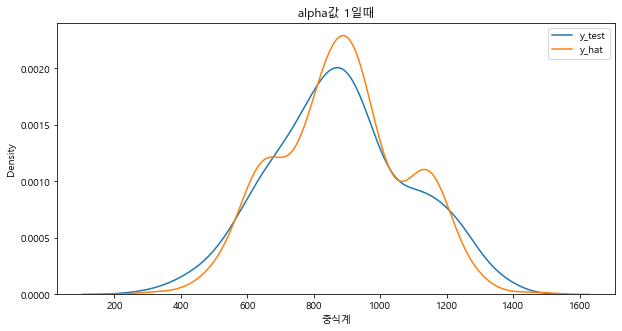

In [305]:
from sklearn.linear_model import Lasso #라쏘
for alpha in [0.1, 0.5, 1, 10, 100]:
    model_lasso = Lasso(alpha=alpha)
    model_lasso.fit(X_train, y_train)
    
    pre =model_lasso.predict(X_test)
    
    print(f'--------------alpha{alpha}값----------------')
    print('R2score=',model_lasso.score(X_test, y_test)) #R2값 1일수록 좋은것
    print('RMSE=',np.sqrt(mean_squared_error(y_test, pre)))
    print('MAE=',mean_absolute_error(y_test, pre))


model_lasso = Lasso(alpha=1)
model_lasso.fit(X_train, y_train)
pre =model_lasso.predict(X_test)

plt.figure(figsize=(10,5))
sns.kdeplot(y_test, label='y_test')
sns.kdeplot(pre, label='y_hat')

plt.title(f'alpha값 {1}일때')
plt.legend()
plt.show()  



### 저녁

In [306]:

param_grid = {'alpha':[0.001, 0.01, 0.1, 1,10,50]}
gird_search = GridSearchCV(Lasso(),param_grid, cv=5, scoring='neg_mean_absolute_error')

gird_search.fit(X2_train,y2_train)
pre =gird_search.predict(X2_test)
print('RMSE=',np.sqrt(mean_squared_error(y2_test, pre)))
print('MAE=',mean_absolute_error(y2_test, pre))
print('r2score=',r2_score(y2_test, pre))

RMSE= 67.04851312652404
MAE= 49.24862692655915
r2score= 0.6164968827028605


In [307]:
perm = PermutationImportance(gird_search, random_state = 42).fit(X2_train,y2_train) 
#eli5.show_weights(perm, top = 20, feature_names = X_train.columns.tolist(),include_styles=True)
eli5.explain_weights_df(perm,feature_names= X2_train.columns.tolist()).head(10)

,feature,weight,std
0,본사시간외근무명령서승인건수,44.597766,0.835158
1,본사휴가자수,18.578760,0.877655
2,요일_금,12.176981,0.339852
3,본사출장자수,10.422970,0.572363
4,현본사소속재택근무자수,6.520004,0.593369
5,본사정원수,5.751006,0.556210
6,휴일다음날,5.308691,0.547784
7,요일_수,4.690192,0.526003
8,요일_월,1.809408,0.228336
9,월_8,1.759971,0.457108


--------------alpha0.1값----------------
0.6164968827028605
RMSE= 67.04029494365165
MAE= 49.22636103151862
--------------alpha0.5값----------------
0.6163828166715011
RMSE= 67.07274842782195
MAE= 49.46991404011462
--------------alpha1값----------------
0.6062816184399995
RMSE= 67.94536824466094
MAE= 50.55587392550143
--------------alpha10값----------------
0.49360445808540643
RMSE= 77.07665592286779
MAE= 59.080229226361034
--------------alpha100값----------------
-0.007465494955759988
RMSE= 108.70067468152055
MAE= 82.5243553008596
0.6163828166715011


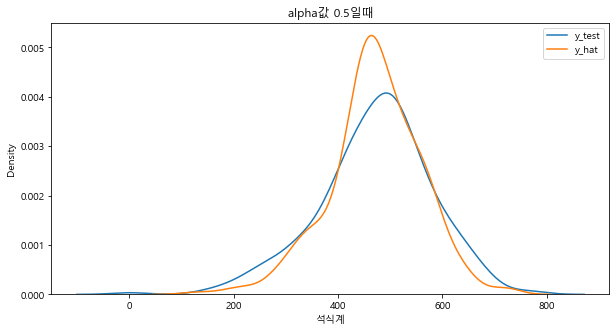

In [308]:
for alpha in [0.1, 0.5, 1, 10, 100]:
    model_lasso = Lasso(alpha=alpha)
    model_lasso.fit(X2_train, y2_train)
    
    pre =model_lasso.predict(X2_test)
    pre =np.round(pre,0)

    print(f'--------------alpha{alpha}값----------------')
    print(model_lasso.score(X2_test, y2_test))
    print('RMSE=',np.sqrt(mean_squared_error(y2_test, pre)))
    print('MAE=',mean_absolute_error(y2_test, pre))

model_lasso = Lasso(alpha=0.5)
model_lasso.fit(X2_train, y2_train)
print(model_lasso.score(X2_test, y2_test))
pre =model_lasso.predict(X2_test)
pre =np.round(pre,0)
plt.figure(figsize=(10,5))
ax1 = sns.kdeplot(y2_test, label='y_test')
ax2 = sns.kdeplot(pre, label='y_hat', ax=ax1)
plt.title(f'alpha값 {0.5}일때')
plt.legend()
plt.show()

## SVM

In [309]:
from sklearn import svm

### 점심

r2= 0.6724463923085617
RMSE= 10.908692962613335
MAE= 90.20441988950276


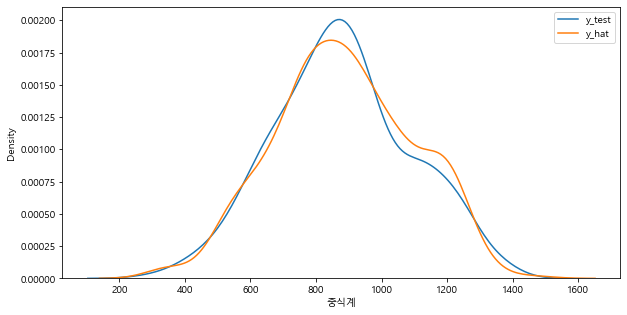

In [310]:

clf = svm.SVC(kernel = 'linear') #다른파라메터 넣어봐도 큰 변화 없음 gamma 등
clf.fit(X_train,y_train)
pre_clf =clf.predict(X_test)

print('r2=',r2_score(y_test,pre_clf))
print('RMSE=',np.sqrt(np.sqrt(mean_squared_error(y_test, pre_clf))))
print('MAE=',mean_absolute_error(y_test, pre_clf))

plt.figure(figsize=(10,5))
ax1 = sns.kdeplot(y_test, label='y_test')
ax2 = sns.kdeplot(pre_clf, label='y_hat', ax=ax1)
plt.legend()
plt.show()

### 저녁

r2= 0.3434312147016467
RMSE= 87.72933107054881
MAE= 65.11747851002865


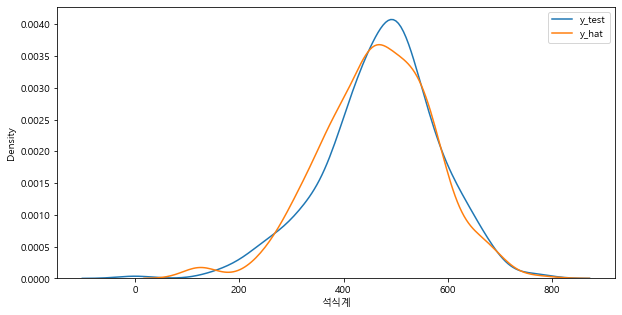

In [311]:
clf = svm.SVC(kernel = 'linear', max_iter=-1)
clf.fit(X2_train,y2_train)
pre_clf =clf.predict(X2_test)

print('r2=',r2_score(y2_test,pre_clf))
print('RMSE=',np.sqrt(mean_squared_error(y2_test, pre_clf)))
print('MAE=',mean_absolute_error(y2_test, pre_clf))

plt.figure(figsize=(10,5))
ax1 = sns.kdeplot(y2_test, label='y_test')
ax2 = sns.kdeplot(pre_clf, label='y_hat', ax=ax1)
plt.legend()
plt.show()

## xgboost

In [312]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from xgboost import XGBRegressor

### 점식

In [313]:
'''param = {
    'max_depth':[2,3,4],
    'n_estimators':range(300,600,100), #  'n_estimators':range(600,700,50) 여기에 cv 10 (이거와 별반차이가 없다.)
    'colsample_bytree':[0.5,0.7,1],
    'colsample_bylevel':[0.5,0.7,1],
}

model = xgb.XGBRegressor()
grid_search = GridSearchCV(estimator=model, param_grid=param, cv=10, 
                           scoring='neg_mean_squared_error',
                           n_jobs=-1)

grid_search.fit(X_train, y_train)

pre = grid_search.predict(X_test)

print(grid_search.score(X_test,y_test))
print('RMSE=',np.sqrt(mean_squared_error(y_test, pre)))
print('MAE=',mean_absolute_error(y_test, pre))

with open('model_rf/XG_lunch_estimator.pickle','wb') as fw: #저장
    pickle.dump(grid_search.best_estimator_, fw)
'''

"param = {\n    'max_depth':[2,3,4],\n    'n_estimators':range(300,600,100), #  'n_estimators':range(600,700,50) 여기에 cv 10 (이거와 별반차이가 없다.)\n    'colsample_bytree':[0.5,0.7,1],\n    'colsample_bylevel':[0.5,0.7,1],\n}\n\nmodel = xgb.XGBRegressor()\ngrid_search = GridSearchCV(estimator=model, param_grid=param, cv=10, \n                           scoring='neg_mean_squared_error',\n                           n_jobs=-1)\n\ngrid_search.fit(X_train, y_train)\n\npre = grid_search.predict(X_test)\n\nprint(grid_search.score(X_test,y_test))\nprint('RMSE=',np.sqrt(mean_squared_error(y_test, pre)))\nprint('MAE=',mean_absolute_error(y_test, pre))\n\nwith open('model_rf/XG_lunch_estimator.pickle','wb') as fw: #저장\n    pickle.dump(grid_search.best_estimator_, fw)\n"

In [314]:
with open('model_rf/XG_lunch_estimator.pickle','rb') as f: #불러오기
    XG_lunch_model = pickle.load(f)

In [315]:
XG_lunch_model = XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=0.5,
             colsample_bynode=1, colsample_bytree=0.5, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=2,
             min_child_weight=1, monotone_constraints='()',
             n_estimators=300, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)
XG_lunch_model.fit(X_train,y_train)


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=0.5,
             colsample_bynode=1, colsample_bytree=0.5, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=2,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=300, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [316]:
pre = XG_lunch_model.predict(X_test)
print(XG_lunch_model.score(X_test,y_test))
print('RMSE=',np.sqrt(mean_squared_error(y_test, pre)))
print('MAE=',mean_absolute_error(y_test, pre))

0.8192815277295004
RMSE= 88.39048485070573
MAE= 65.85229580705337


저녁

In [317]:
'''
param = {
    'max_depth':[2,3,4],
    'n_estimators':range(300,600,100), #  'n_estimators':range(600,700,50) 여기에 cv 10 (이거와 별반차이가 없다.)
    'colsample_bytree':[0.5,0.7,1],
    'colsample_bylevel':[0.5,0.7,1],
}

model = xgb.XGBRegressor()
grid_search = GridSearchCV(estimator=model, param_grid=param, cv=10, 
                           scoring='neg_mean_squared_error',
                           n_jobs=-1)

grid_search.fit(X2_train, y2_train)

pre = grid_search.predict(X2_test)

print(grid_search.score(X2_test,y2_test))
print('RMSE=',np.sqrt(mean_squared_error(y2_test, pre)))
print('MAE=',mean_absolute_error(y2_test, pre))

with open('model_rf/XG_dinner_estimator.pickle','wb') as fw: ##저장
    pickle.dump(grid_search.best_estimator_, fw)
'''

"\nparam = {\n    'max_depth':[2,3,4],\n    'n_estimators':range(300,600,100), #  'n_estimators':range(600,700,50) 여기에 cv 10 (이거와 별반차이가 없다.)\n    'colsample_bytree':[0.5,0.7,1],\n    'colsample_bylevel':[0.5,0.7,1],\n}\n\nmodel = xgb.XGBRegressor()\ngrid_search = GridSearchCV(estimator=model, param_grid=param, cv=10, \n                           scoring='neg_mean_squared_error',\n                           n_jobs=-1)\n\ngrid_search.fit(X2_train, y2_train)\n\npre = grid_search.predict(X2_test)\n\nprint(grid_search.score(X2_test,y2_test))\nprint('RMSE=',np.sqrt(mean_squared_error(y2_test, pre)))\nprint('MAE=',mean_absolute_error(y2_test, pre))\n\nwith open('model_rf/XG_dinner_estimator.pickle','wb') as fw: ##저장\n    pickle.dump(grid_search.best_estimator_, fw)\n"

In [318]:
with open('model_rf/XG_dinner_estimator.pickle','rb') as f:
    XG_dinner_model = pickle.load(f)

In [319]:
XG_dinner_model =XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=2,
             min_child_weight=1,monotone_constraints='()',
             n_estimators=300, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)
XG_dinner_model.fit(X2_train,y2_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=2,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=300, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [320]:
pre = XG_dinner_model.predict(X2_test)
print(XG_dinner_model.score(X2_test,y2_test))
print('RMSE=',np.sqrt(mean_squared_error(y2_test, pre)))
print('MAE=',mean_absolute_error(y2_test, pre))

0.5936722352393125
RMSE= 69.01491408268036
MAE= 48.970381772279055


## 랜덤포레스트 모델

## 점심 저녁 한번예

In [321]:
'''
params = {#max_depth=10, n_estimators=50, n_jobs=-1, random_state=42
    'n_estimators': [50,100,150,300,1000],
    'max_features': ['auto', 'sqrt'],
    'max_depth' : [1,3,6,10],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 3, 5, 10]}

model1 = RandomForestRegressor(n_jobs=-1, random_state=42)
model2 = RandomForestRegressor(n_jobs=-1, random_state=42)

RF_lunch_model = GridSearchCV(model1, params, scoring='neg_mean_absolute_error')
RF_dinner_model = GridSearchCV(model2, params, scoring='neg_mean_absolute_error')

RF_lunch_model.fit(X_train, y_train)
RF_dinner_model.fit(X2_train, y2_train)

RF_lunch_best = RF_lunch_model.best_score_
RF_dinner_best = RF_dinner_model.best_score_

print('점심 RF 모델 에러값(mae) : ',RF_lunch_best)
print('저녁 RF 모델 에러값(mae) : ',RF_dinner_best)

rf_lunch_param=RF_lunch_model.best_params_
rf_lunch_est = RF_lunch_model.best_estimator_

rf_dinner_param=RF_dinner_model.best_params_
rf_lunch_est = RF_dinner_model.best_estimator_

with open('model_rf/rf_lunch_estimator.pickle','wb') as fw:
    pickle.dump(RF_lunch_model.best_estimator_, fw)
with open('model_rf/rf_dinner_estimator.pickle','wb') as fw:
    pickle.dump(RF_dinner_model.best_estimator_, fw)
# 모델값저장
'''


"\nparams = {#max_depth=10, n_estimators=50, n_jobs=-1, random_state=42\n    'n_estimators': [50,100,150,300,1000],\n    'max_features': ['auto', 'sqrt'],\n    'max_depth' : [1,3,6,10],\n    'min_samples_leaf': [1, 2, 4],\n    'min_samples_split': [2, 3, 5, 10]}\n\nmodel1 = RandomForestRegressor(n_jobs=-1, random_state=42)\nmodel2 = RandomForestRegressor(n_jobs=-1, random_state=42)\n\nRF_lunch_model = GridSearchCV(model1, params, scoring='neg_mean_absolute_error')\nRF_dinner_model = GridSearchCV(model2, params, scoring='neg_mean_absolute_error')\n\nRF_lunch_model.fit(X_train, y_train)\nRF_dinner_model.fit(X2_train, y2_train)\n\nRF_lunch_best = RF_lunch_model.best_score_\nRF_dinner_best = RF_dinner_model.best_score_\n\nprint('점심 RF 모델 에러값(mae) : ',RF_lunch_best)\nprint('저녁 RF 모델 에러값(mae) : ',RF_dinner_best)\n\nrf_lunch_param=RF_lunch_model.best_params_\nrf_lunch_est = RF_lunch_model.best_estimator_\n\nrf_dinner_param=RF_dinner_model.best_params_\nrf_lunch_est = RF_dinner_model.best_esti

In [322]:
'''print(rf_lunch_param, rf_lunch_est, rf_dinner_param, rf_lunch_est)'''

'print(rf_lunch_param, rf_lunch_est, rf_dinner_param, rf_lunch_est)'

In [323]:
with open('model_rf/rf_lunch_estimator.pickle','rb') as f:
    RF_lunch_model = pickle.load(f)
with open('model_rf/rf_dinner_estimator.pickle','rb') as f:
    RF_dinner_model = pickle.load(f)
RF_lunch_model = RandomForestRegressor(max_depth=10, n_estimators=300, n_jobs=-1,
                      random_state=42)
RF_dinner_model = RandomForestRegressor(max_depth=10, n_estimators=300, n_jobs=-1,
                      random_state=42)
RF_lunch_model.fit(X_train,y_train)
RF_dinner_model.fit(X2_train, y2_train)


RandomForestRegressor(max_depth=10, n_estimators=300, n_jobs=-1,
                      random_state=42)

In [324]:
pre_lunch = RF_lunch_model.predict(X_test)
pre_dinner = RF_dinner_model.predict(X2_test)
print('-----------점심 ------------')
print(RF_lunch_model.score(X_test,y_test))
print('RMSE=',np.sqrt(mean_squared_error(y_test, pre_lunch)))
print('MAE=',mean_absolute_error(y_test, pre_lunch))
print('-----------저녁---------------')
print(RF_dinner_model.score(X2_test,y2_test))
print('RMSE=',np.sqrt(mean_squared_error(y2_test, pre_dinner)))
print('MAE=',mean_absolute_error(y2_test, pre_dinner))

-----------점심 ------------
0.8415324591982098
RMSE= 82.77027574597417
MAE= 63.231266554239554
-----------저녁---------------
0.6502828411738835
RMSE= 64.02700287509631
MAE= 47.62113403601142


## KNN

## 점심

In [325]:
from sklearn.neighbors import KNeighborsRegressor

grid_params = {
    'n_neighbors' : list(range(1,20)),
    'weights' : ["uniform", "distance"],
    'metric' : ['euclidean', 'manhattan', 'minkowski']
}

grid_model = GridSearchCV(KNeighborsRegressor(), grid_params, scoring='neg_mean_absolute_error')

grid_model.fit(X_train, y_train) 
pre = grid_model.predict(X_test)

print(grid_model.score(X_test,y_test))
print('r2=',r2_score(y_test,pre))
print('RMSE=',np.sqrt(mean_squared_error(y_test, pre)))
print('MAE=',mean_absolute_error(y_test, pre))

-72.86831762223294
r2= 0.7926336078880628
RMSE= 94.68330930522926
MAE= 72.86831762223294


## 저녁

In [326]:
from sklearn.neighbors import KNeighborsRegressor

grid_params = {
    'n_neighbors' : list(range(1,20)),
    'weights' : ["uniform", "distance"],
    'metric' : ['euclidean', 'manhattan', 'minkowski']
}

grid_model = GridSearchCV(KNeighborsRegressor(), grid_params, scoring='neg_mean_absolute_error')

grid_model.fit(X2_train, y2_train) 
pre = grid_model.predict(X2_test)

print(grid_model.score(X2_test,y2_test))
print('r2=',r2_score(y2_test,pre))
print('RMSE=',np.sqrt(mean_squared_error(y2_test, pre)))
print('MAE=',mean_absolute_error(y2_test, pre))

-50.360585164964185
r2= 0.6076928775961288
RMSE= 67.81375588364365
MAE= 50.360585164964185
